* SJSU ID - 010816832
* VIDYA COIMBATORE NAND KUMAR
* Alternus Vera Assignment

## **Analyse Influence of Controversy on Fake news dataset

* The aim of the project is to develop a strategy to help identify fake news from real news and understand the influence of Controversy and other factors. 
* The subject of fake news became popular in connection with the recent US presidential elections and with possible Russian meddling into elections in the US, France, and Germany. 
* The project uses LIAR - LIAR  dataset.
* LDA,LSA,gensim and sentiment analysis methods have been used for distillation


We identified several factors that could contribute to fake news detection, by analysing the dataset.
Key factors identified are:
* Political affiliation
* Sentimental Analysis
* Controversy
* Topic features 
* Post/Social media activities based: People express their emotions or opinions towards fake news through social media posts.
* Visual based: Fake news detection based on images and video links features in the dataset.
* Linguistic based: Fake news detection based on Sensationalism and writing style (features: Article title and text)
* Reliable source: Fake news detection based on the source of the article.
* Authenticity: Fake news includes false information that can be verified as such.

#### Goal 
To compare the effectiveness of LDA, LSA, tfidf-cosine similarity, doc2vec to find the degree of controversiveness in statements and to evaluate the performance of the multi class model in predicting the following labels for news statements-	barely_true,	false,	half_true,	mostly_true and	pants_on_fire.


In [270]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from collections import Counter
import nltk
from nltk.tokenize import RegexpTokenizer
import re
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from graphviz import Digraph
from collections import OrderedDict
import seaborn as sns
sns.set_style("darkgrid")

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk

path_train='train.tsv'
path_test='test.tsv'
path_valid='valid.tsv'
path_controversy_vocab = 'controversy_vocabulary.csv'




## Loading Training, Test and Validation data

In [271]:
train_data = pd.read_csv(path_train, sep='\t', header = None)
test_data = pd.read_csv(path_test, sep='\t', header = None)
valid_data = pd.read_csv(path_valid, sep='\t', header = None)

contro_vocab_data = pd.read_csv(path_controversy_vocab)
contro_vocab_data.head()
columns = ['id', 'label', 'statement', 'subjects', 'speaker',
         'speaker_job', 'state', 'party', 'barely_true_counts',
         'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts',
         'context']
train_data.columns = columns
test_data.columns = columns
valid_data.columns = columns


#### Adding text length to training set

In [272]:
train_data['text-length'] = train_data['statement'].apply(len)
#train_data.head()

## Visualizing the dataset 

### Distribution of classes based on labels - Train ,Test and Validation datasets

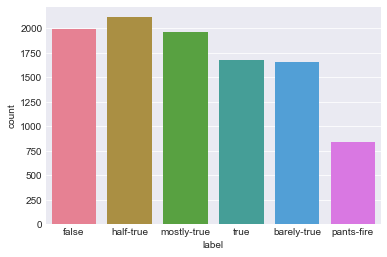

In [273]:
sb.countplot(x='label', data=train_data, palette='husl')

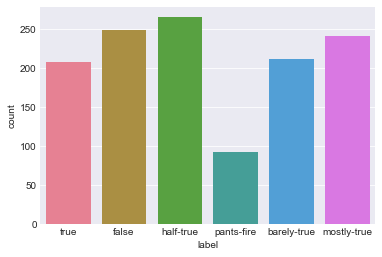

In [274]:
sb.countplot(x='label', data=test_data, palette='husl')

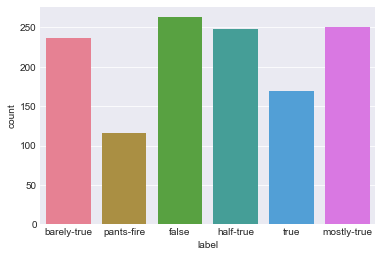

In [275]:
sb.countplot(x='label', data=valid_data, palette='husl')

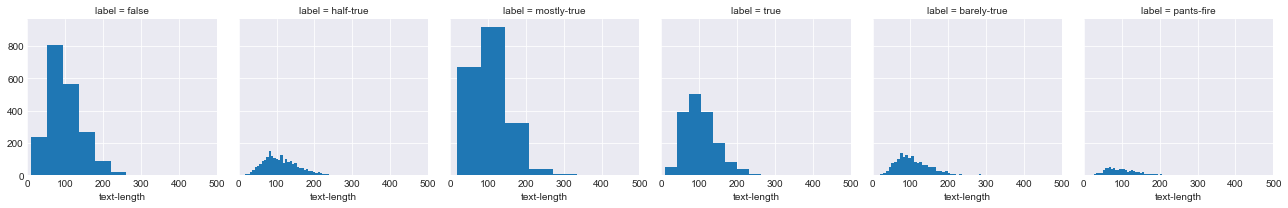

In [276]:
g = sns.FacetGrid(data=train_data, col='label')
for i, ax in enumerate(g.axes.flat): # set every-other axis for testing purposes
       ax.set_xlim(0,500)
g.map(plt.hist, 'text-length', bins=50)


* Seems like overall, the distribution of text length is similar across all labels. However, the number of text length seems to be skewed a lot higher for false and mostly-true labels. 

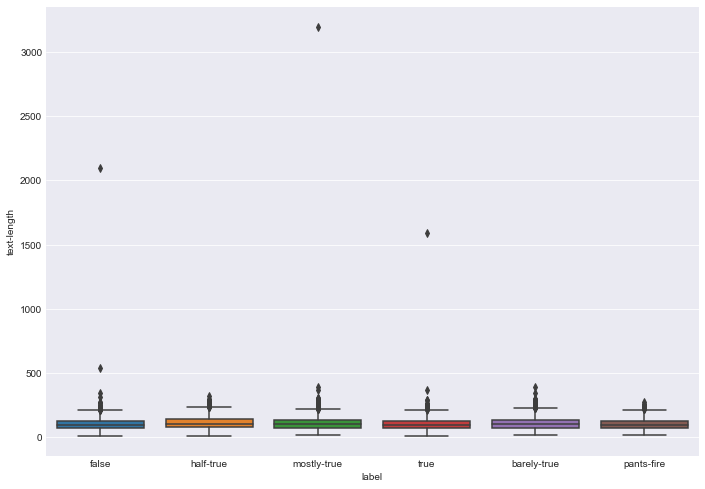

In [277]:
a4_dims = (11.7, 8.27)
f, ax = plt.subplots(figsize=a4_dims)
sns.set_style("whitegrid")
sns.boxplot(x='label', y='text-length', data=train_data)

#### From the plot I  inferred that 'false' 'mostly-true' and 'true' have much longer text, but there are many outliers too which can be seen as points above the boxes

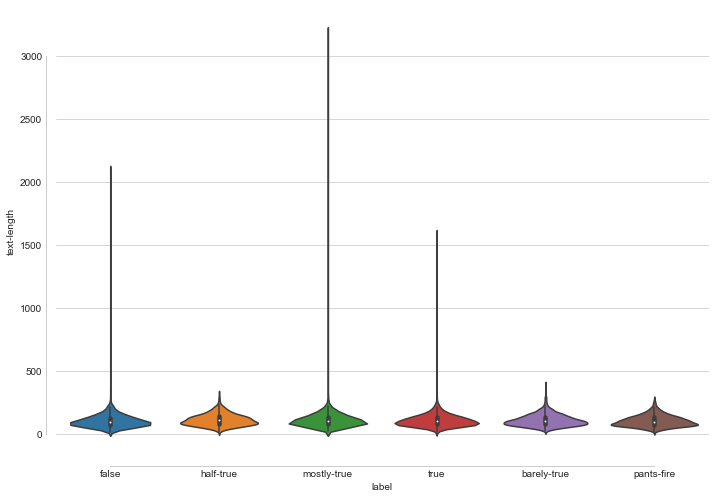

In [278]:
a4_dims = (11.7, 8.27)
f, ax = plt.subplots(figsize=a4_dims)
sns.violinplot(x='label', y='text-length', data=train_data)
sns.despine(offset=10, trim=True);

In [279]:
train_data.describe()

,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,text-length
count,10238.000000,10238.000000,10238.000000,10238.000000,10238.000000,10240.000000
mean,11.533210,13.286482,17.133718,16.434265,6.201407,106.918750
std,18.973764,24.112936,35.846511,36.151688,16.128927,59.917722
min,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000
50%,2.000000,2.000000,3.000000,3.000000,1.000000,99.000000
75%,12.000000,12.000000,13.000000,11.000000,5.000000,132.250000
max,70.000000,114.000000,160.000000,163.000000,105.000000,3192.000000


In [280]:
labels = train_data.groupby('label').mean()
labels.corr()

,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,text-length
barely_true_counts,1.000000,-0.127664,0.305618,0.283077,-0.348281,0.520355
false_counts,-0.127664,1.000000,-0.823283,-0.851132,0.925060,-0.731996
half_true_counts,0.305618,-0.823283,1.000000,0.983699,-0.851951,0.740105
mostly_true_counts,0.283077,-0.851132,0.983699,1.000000,-0.875937,0.696002
pants_on_fire_counts,-0.348281,0.925060,-0.851951,-0.875937,1.000000,-0.645328
text-length,0.520355,-0.731996,0.740105,0.696002,-0.645328,1.000000


### Feature selection or attribute evaluator consists of identifying the relevant features and ignoring the irrelevant ones from a dataset. The use of attribute evaluator methods enhances the performance of machine learning algorithms. Visualizing Correlation heatmap helps in better correlation-based feature selection

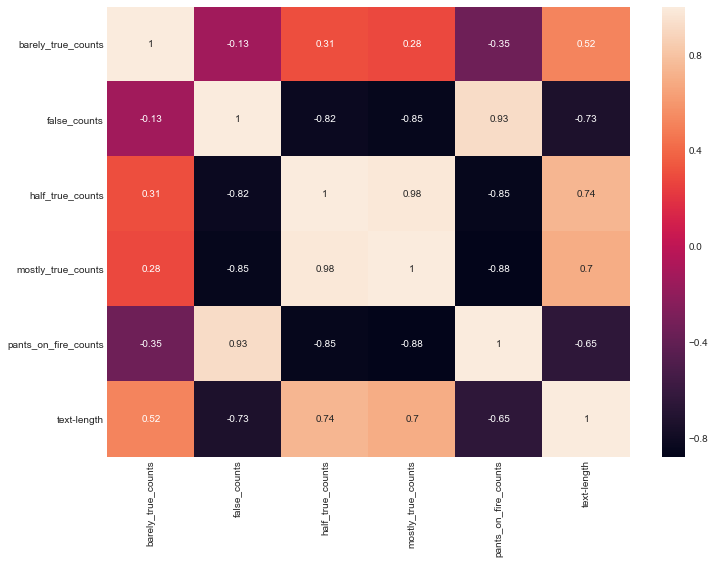

In [281]:
from matplotlib import pyplot
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.heatmap(ax=ax,data=labels.corr(), annot=True)


* Looking at the map, false is strongly correlated with pants_on_fire, and mostly_true seems strongly correlated with half_true. There is also a negative correlation between false_counts and the other features.

### Visualizing mostly used words corresponding to True, False, barely-true, mostly-true, half-true, pants-fire labels

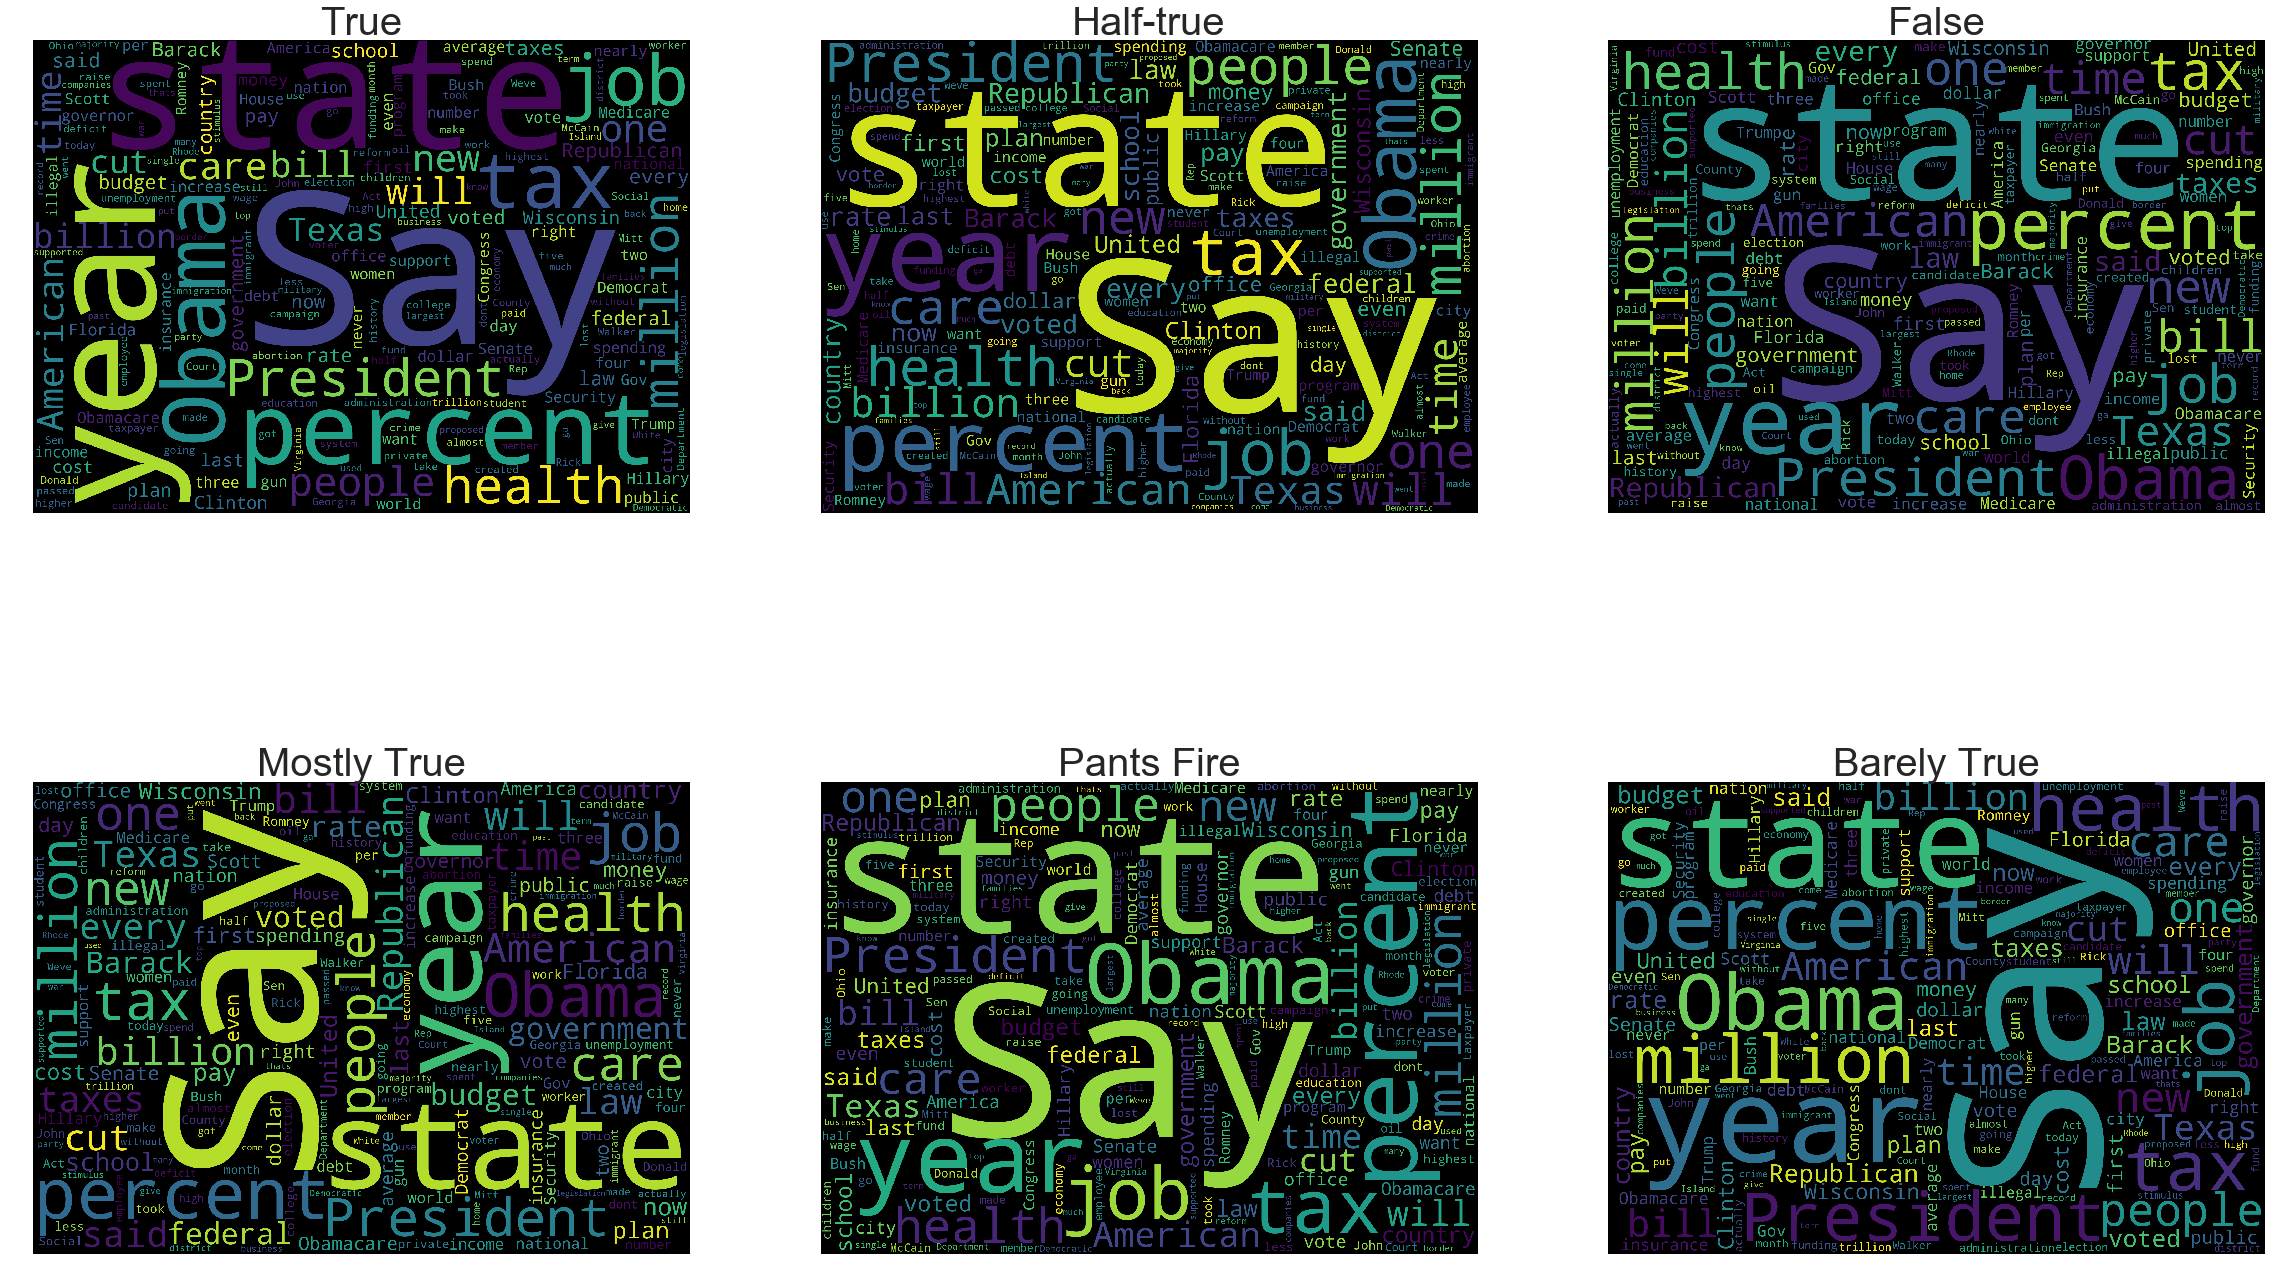

In [393]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(40,25))
# true
subset = train_data[train_data.label==True]
text = train_data['statement']
cloud_true = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))


plt.subplot(2, 3, 1)
plt.axis('off')
plt.title("True",fontsize=40)
plt.imshow(cloud_true)

# true
subset = train_data[train_data.label=='half-true']
text = train_data['statement']
cloud_half_true = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 2)
plt.axis('off')
plt.title("Half-true",fontsize=40)
plt.imshow(cloud_half_true)



# false
subset = train_data[train_data.label=='false']
text = train_data['statement']
cloud_false = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 3)
plt.axis('off')
plt.title("False",fontsize=40)
plt.imshow(cloud_false)



# mostly-true
subset = train_data[train_data.label=='mostly-true']
text = train_data['statement']
cloud_mostly_true = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 4)
plt.axis('off')
plt.title("Mostly True",fontsize=40)
plt.imshow(cloud_mostly_true)

#pants-fire
subset = train_data[train_data.label=='pants-fire']
text = train_data['statement']
cloud_pants_fire = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 5)
plt.axis('off')
plt.title("Pants Fire",fontsize=40)
plt.imshow(cloud_pants_fire)


#barely-true
subset = train_data[train_data.label=='barely-true']
text = train_data['statement']
cloud_barely_true = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 6)
plt.axis('off')
plt.title("Barely True",fontsize=40)
plt.imshow(cloud_barely_true)

### An important set of metrics in text mining relates to the frequency of words or token in a certain corpus of text documents. 
* Following is the frequency distribution (list) of most frequently used words among the statements in traning data set

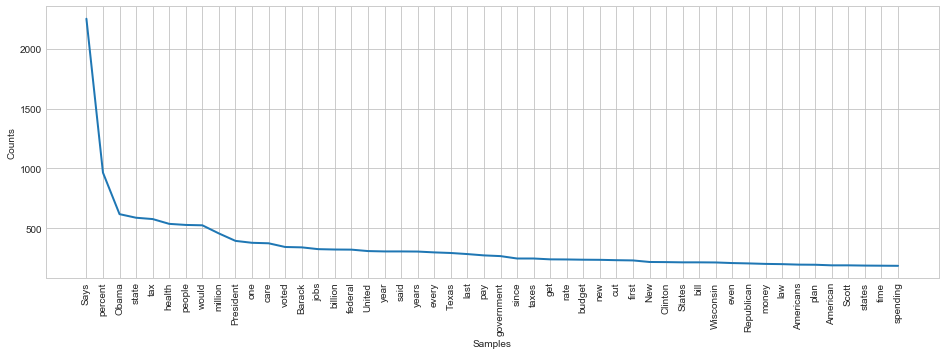

In [386]:
from collections import defaultdict

import pandas as pd

word_list=[]
word_freq = defaultdict(int)

for text in train_data.statement:
    for word in text.split():
        if word.lower() not in stop_words and word.isalpha():
            word_list.append(word)
            word_freq[word] += 1

pd.DataFrame.from_dict(word_freq, orient='index') \
.sort_values(0, ascending=False) \
.rename(columns={0: 'abs_freq'})

freqdist = nltk.FreqDist(word_list)
plt.figure(figsize=(16,5))
freqdist.plot(50)


The words 'Says','percent','Obama' are frequently used

In [ ]:
fd = nltk.ConditionalFreqDist(
           (genre, len(word))
           for genre in brown.categories()
           for word in get_brown_corpus_words(genre))

plt.figure(figsize=(16,8))
cfd.plot()

## Forming Vocabulary of Controversial words

 * Using a four-point scale to classify 200 high-frequency terms analysed from 
   * https://wpcurve.com/words-that-trigger-emotional-responses/
   * https://www.scribd.com/doc/82701103/Analyst-Desktop-Binder-REDACTED
   * https://arxiv.org/pdf/1409.8152.pdf

Indicate if word is based on threshold:
* Strongly Controversial: 
* Somewhat Controversial:
* Less Controversial
* Non-Controversial: 

In [283]:
vocab_doc = ["abuse administration afghanistan aid america american army attack attacks authorities authority ban banks benefits bill border budget campaign candidate candidates catholic china chinese church concerns congress conservative control country court crime criminal crisis cuts debate debt defense deficit democrats disease dollar drug drugs economy education egypt election elections enforcement fighting finance fiscal force funding gas government gun health immigration inaccuracies india insurance investigation investigators iran israel job jobs judge justice killing korea labor land law lawmakers laws lawsuit leadership legislation marriage media mexico military money murder nation nations news obama offensive officials oil parties peace police policies policy politics poll power president prices primary prison progress race reform republican republicans restrictions rule rules ruling russia russian school security senate sex shooting society spending strategy strike support syria syrian tax taxes threat trial unemployment union usa victim violence vote voters war washington weapons world account advantage amount attorney chairman charge charges cities class comment companies cost credit delays effect expectations families family february germany goal housing information investment markets numbers oklahoma parents patients population price projects raise rate reason sales schools sector shot source sources status stock store whether worth"]


## Data pre-processing 
* Check for missing or null values
* Lowercase
* Tokenize
* Remove stop words, punctuations and special characters
* Stem


### Categorize label column

In [284]:
train_data['label_id'] = train_data['label'].factorize()[0]

In [285]:
train_data.isnull().sum()

id                         0
label                      0
statement                  0
subjects                   2
speaker                    2
speaker_job             2897
state                   2208
party                      2
barely_true_counts         2
false_counts               2
half_true_counts           2
mostly_true_counts         2
pants_on_fire_counts       2
context                  102
text-length                0
label_id                   0
dtype: int64

In [286]:
train_data.info()
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 16 columns):
id                      10240 non-null object
label                   10240 non-null object
statement               10240 non-null object
subjects                10238 non-null object
speaker                 10238 non-null object
speaker_job             7343 non-null object
state                   8032 non-null object
party                   10238 non-null object
barely_true_counts      10238 non-null float64
false_counts            10238 non-null float64
half_true_counts        10238 non-null float64
mostly_true_counts      10238 non-null float64
pants_on_fire_counts    10238 non-null float64
context                 10138 non-null object
text-length             10240 non-null int64
label_id                10240 non-null int64
dtypes: float64(5), int64(2), object(9)
memory usage: 1.3+ MB


In [287]:
test_data.isnull().sum()

id                        0
label                     0
statement                 0
subjects                  0
speaker                   0
speaker_job             325
state                   262
party                     0
barely_true_counts        0
false_counts              0
half_true_counts          0
mostly_true_counts        0
pants_on_fire_counts      0
context                  17
dtype: int64

In [288]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 14 columns):
id                      1267 non-null object
label                   1267 non-null object
statement               1267 non-null object
subjects                1267 non-null object
speaker                 1267 non-null object
speaker_job             942 non-null object
state                   1005 non-null object
party                   1267 non-null object
barely_true_counts      1267 non-null int64
false_counts            1267 non-null int64
half_true_counts        1267 non-null int64
mostly_true_counts      1267 non-null int64
pants_on_fire_counts    1267 non-null int64
context                 1250 non-null object
dtypes: int64(5), object(9)
memory usage: 138.7+ KB


In [289]:
valid_data.isnull().sum()

id                        0
label                     0
statement                 0
subjects                  0
speaker                   0
speaker_job             345
state                   279
party                     0
barely_true_counts        0
false_counts              0
half_true_counts          0
mostly_true_counts        0
pants_on_fire_counts      0
context                  12
dtype: int64

In [290]:
valid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1284 entries, 0 to 1283
Data columns (total 14 columns):
id                      1284 non-null object
label                   1284 non-null object
statement               1284 non-null object
subjects                1284 non-null object
speaker                 1284 non-null object
speaker_job             939 non-null object
state                   1005 non-null object
party                   1284 non-null object
barely_true_counts      1284 non-null int64
false_counts            1284 non-null int64
half_true_counts        1284 non-null int64
mostly_true_counts      1284 non-null int64
pants_on_fire_counts    1284 non-null int64
context                 1272 non-null object
dtypes: int64(5), object(9)
memory usage: 140.5+ KB


In [291]:
label_id_df = train_data[['label', 'label_id']].sort_values('label_id')
label_to_id = dict(label_id_df.values)
id_to_label = dict(label_id_df[['label_id', 'label']].values)

In [292]:
label_to_id

{'false': 0,
 'half-true': 1,
 'mostly-true': 2,
 'true': 3,
 'barely-true': 4,
 'pants-fire': 5}

In [293]:
train_data.head()

,id,label,statement,subjects,speaker,speaker_job,state,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,text-length,label_id
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,82,0
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,141,1
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,105,2
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,78,0
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,54,1


### Parts of speech tagging can be important for syntactic and semantic analysis, for each word in news can have several semantic meanings. 
### Frequency distribution of Part of Speech Tags:
* Noun Count
* Verb Count
* Adjective Count
* Adverb Count
* Pronoun Count

In [294]:
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

train_data['noun_count'] = train_data['statement'].apply(lambda x: check_pos_tag(x, 'noun'))
train_data['verb_count'] = train_data['statement'].apply(lambda x: check_pos_tag(x, 'verb'))
train_data['adj_count'] = train_data['statement'].apply(lambda x: check_pos_tag(x, 'adj'))
train_data['adv_count'] = train_data['statement'].apply(lambda x: check_pos_tag(x, 'adv'))
train_data['pron_count'] = train_data['statement'].apply(lambda x: check_pos_tag(x, 'pron'))

In [295]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

In [296]:
ex = 'European authorities fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices'

In [297]:
def processtag(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent

In [298]:
sent = processtag(ex)
sent

[('European', 'JJ'),
 ('authorities', 'NNS'),
 ('fined', 'VBD'),
 ('Google', 'NNP'),
 ('a', 'DT'),
 ('record', 'NN'),
 ('$', '$'),
 ('5.1', 'CD'),
 ('billion', 'CD'),
 ('on', 'IN'),
 ('Wednesday', 'NNP'),
 ('for', 'IN'),
 ('abusing', 'VBG'),
 ('its', 'PRP$'),
 ('power', 'NN'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('mobile', 'JJ'),
 ('phone', 'NN'),
 ('market', 'NN'),
 ('and', 'CC'),
 ('ordered', 'VBD'),
 ('the', 'DT'),
 ('company', 'NN'),
 ('to', 'TO'),
 ('alter', 'VB'),
 ('its', 'PRP$'),
 ('practices', 'NNS')]

In [299]:
from nltk.chunk import conlltags2tree, tree2conlltags
from pprint import pprint
iob_tagged = tree2conlltags(sent)
pprint(iob_tagged)

[('European', 'JJ', 'O'),
 ('authorities', 'NNS', 'O'),
 ('fined', 'VBD', 'O'),
 ('Google', 'NNP', 'O'),
 ('a', 'DT', 'O'),
 ('record', 'NN', 'O'),
 ('$', '$', 'O'),
 ('5.1', 'CD', 'O'),
 ('billion', 'CD', 'O'),
 ('on', 'IN', 'O'),
 ('Wednesday', 'NNP', 'O'),
 ('for', 'IN', 'O'),
 ('abusing', 'VBG', 'O'),
 ('its', 'PRP$', 'O'),
 ('power', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('mobile', 'JJ', 'O'),
 ('phone', 'NN', 'O'),
 ('market', 'NN', 'O'),
 ('and', 'CC', 'O'),
 ('ordered', 'VBD', 'O'),
 ('the', 'DT', 'O'),
 ('company', 'NN', 'O'),
 ('to', 'TO', 'O'),
 ('alter', 'VB', 'O'),
 ('its', 'PRP$', 'O'),
 ('practices', 'NNS', 'O')]


In [395]:
#train_data.head(50)

#### Apply Stemming , Lemmatization and remove Stopwords and special characters from News Statement column
* Check for missing or null values
* Lowercase
* Tokenize
* Remove stop words, punctuations and special characters
* Stem

In [301]:
from nltk.corpus import wordnet as wn

def preprocess(raw_news):
    import nltk    
    news = re.sub("[^a-zA-Z]", " ", raw_news)    
    news =  news.lower()     
    news_words = nltk.word_tokenize( news)        
    stops = set(nltk.corpus.stopwords.words("english"))       
    words = [w for w in  news_words  if not w in stops]        
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in words]     
    return " ".join(stems)


import re
train_data['stemmed'] = train_data["statement"].apply(preprocess) 
#testing['statement'] = testing["statement"].apply(cleaning)
print(len(train_data), "statements")
#print(len(testing), "statements")

pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

def lemmatize(self, word, pos=wn.NOUN):
    lemmas = wordnet._morphy(word, pos)
    return min(lemmas, key=len) if lemmas else word



10240 statements


In [302]:
from nltk.corpus import stopwords
import time
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))
# clean text and title and create new column "tokenized"
t1 = time.time()
train_data['tokenized'] = train_data['statement'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(train_data), "articles:", (t2-t1)/60, "min")


Time to clean and tokenize 10240 articles: 0.27494448026021323 min


In [303]:
import string
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [453]:
#train_data.head()

### Tokenize the Controversy vocab document

In [305]:
# tokenize

texts = ([list(set([stemmer.stem(word) for word in vocab_doc[0].split()]))])
print(texts)


[['chines', 'offens', 'budget', 'forc', 'marriag', 'media', 'violenc', 'administr', 'statu', 'obama', 'insur', 'chairman', 'citi', 'countri', 'murder', 'inform', 'support', 'congress', 'health', 'labor', 'sex', 'school', 'usa', 'militari', 'syria', 'power', 'russia', 'charg', 'educ', 'account', 'sector', 'judg', 'cost', 'concern', 'ga', 'enforc', 'campaign', 'progress', 'sourc', 'rais', 'oil', 'class', 'lawmak', 'debt', 'defens', 'diseas', 'comment', 'bill', 'america', 'fiscal', 'vote', 'attorney', 'market', 'unemploy', 'credit', 'popul', 'reform', 'strike', 'kill', 'trial', 'senat', 'februari', 'economi', 'abus', 'washington', 'israel', 'rule', 'effect', 'american', 'drug', 'crisi', 'conserv', 'republican', 'union', 'cathol', 'debat', 'attack', 'polic', 'rate', 'job', 'legisl', 'project', 'famili', 'money', 'victim', 'presid', 'poll', 'armi', 'crime', 'shoot', 'hous', 'leadership', 'war', 'ban', 'parti', 'russian', 'deficit', 'reason', 'elect', 'prison', 'crimin', 'iran', 'whether', '

### Create a dictionary of vocabulary words
The classifiers and learning algorithms can not directly process the text documents in their original form, as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length. Therefore,the texts are converted to a more manageable representation.

One way of extracting features from text is to use the bag of words model: a model where for each document, containing the controversial terms, the presence and  frequency of words is taken into consideration, but the order in which they occur is ignored.

In [306]:
import gensim
dictionary = gensim.corpora.Dictionary(texts)

dictionary.save('/Users/vidya/vocab_list.dict')
print(dictionary[5])
print(dictionary.token2id['expect'])

aid
58


In [307]:
print(dictionary)

Dictionary(170 unique tokens: ['abus', 'account', 'administr', 'advantag', 'afghanistan']...)


In [308]:
print(dictionary.token2id)

{'abus': 0, 'account': 1, 'administr': 2, 'advantag': 3, 'afghanistan': 4, 'aid': 5, 'america': 6, 'american': 7, 'amount': 8, 'armi': 9, 'attack': 10, 'attorney': 11, 'author': 12, 'ban': 13, 'bank': 14, 'benefit': 15, 'bill': 16, 'border': 17, 'budget': 18, 'campaign': 19, 'candid': 20, 'cathol': 21, 'chairman': 22, 'charg': 23, 'china': 24, 'chines': 25, 'church': 26, 'citi': 27, 'class': 28, 'comment': 29, 'compani': 30, 'concern': 31, 'congress': 32, 'conserv': 33, 'control': 34, 'cost': 35, 'countri': 36, 'court': 37, 'credit': 38, 'crime': 39, 'crimin': 40, 'crisi': 41, 'cut': 42, 'debat': 43, 'debt': 44, 'defens': 45, 'deficit': 46, 'delay': 47, 'democrat': 48, 'diseas': 49, 'dollar': 50, 'drug': 51, 'economi': 52, 'educ': 53, 'effect': 54, 'egypt': 55, 'elect': 56, 'enforc': 57, 'expect': 58, 'famili': 59, 'februari': 60, 'fight': 61, 'financ': 62, 'fiscal': 63, 'forc': 64, 'fund': 65, 'ga': 66, 'germani': 67, 'goal': 68, 'govern': 69, 'gun': 70, 'health': 71, 'hous': 72, 'imm

In [309]:
new_doc = "credit budget violenc"
new_vec = dictionary.doc2bow(new_doc.lower().split())
print(new_vec)

[(18, 1), (38, 1), (161, 1)]


#### Create doc2bow() of the tokenized texts, to count the number of occurences of each distinct word, and convert the word to its integer word id and returns the result as a sparse vector
* store the serialized corpus in memory

In [310]:
corpus = [dictionary.doc2bow(text) for text in texts]
gensim.corpora.MmCorpus.serialize('/Users/vidya/vocab_list.mm', corpus) 

In [311]:
print(corpus)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

### Load dictionary and corpus

In [312]:
from gensim import corpora, models, similarities
dictionary = corpora.Dictionary.load('/Users/vidya/vocab_list.dict')
corpus = corpora.MmCorpus('/Users/vidya/vocab_list.mm')
print(corpus)

MmCorpus(1 documents, 170 features, 170 non-zero entries)


### Create the transformation model for corpus using tfidf

### Analyse Controversy Influence factor using Latent Semantic Analysis
* Compute possible similarities based on apparent semantic relatedness of texts (words)
* Using “Indexing by Latent Semantic Analysis” 

In [313]:
tf_idf = gensim.models.TfidfModel(corpus)
print(tf_idf)
s = 0
for i in corpus:
    s += len(i)
print(s)

TfidfModel(num_docs=1, num_nnz=170)
170


In [314]:
corpus_tfidf = tf_idf[corpus]
print(corpus_tfidf)

In [315]:
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=2)
print(lsi)

LsiModel(num_terms=170, num_topics=2, decay=1.0, chunksize=20000)


In [316]:
lsi.print_topics(10)

[(0,
  '0.077*"comment" + 0.077*"candid" + 0.077*"campaign" + 0.077*"bank" + 0.077*"charg" + 0.077*"advantag" + 0.077*"church" + 0.077*"administr" + 0.077*"amount" + 0.077*"goal"')]

In [317]:
doc1 = "Human politics russian banks"
vec_bow1 = dictionary.doc2bow(doc1.lower().split())
#print(vec_bow1)
vec_lsi1 = lsi[vec_bow1] # convert the query to LSI space
print(vec_lsi1[0][1]) #LSI index



0.07669649888473705


## Similarity score

In [318]:
index = similarities.MatrixSimilarity(lsi[corpus])
sims = index[vec_lsi1]
print(list(enumerate(sims)))

[(0, 1.0)]


/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


### Computing LSA MatrixSimilarity index for all news statements in training dataset

In [399]:
LSA_score=[]
mydict={}

for data in train_data['stemmed']:
    vec_bow2 = dictionary.doc2bow(data.lower().split())
    vec_lsi2 = lsi[vec_bow2] # convert the query to LSI space
    mydict[data] = vec_lsi2
    if len(vec_lsi2) >= 1:
        LSA_score.append(vec_lsi2[0][1])
    else:
        LSA_score.append(0)
       
       
sorted_mydict = OrderedDict(sorted(mydict.items(), key=lambda x: x[1], reverse=True))
count=0
for key,val in sorted_mydict.items():
    if val and (count > 3 and count < 10):
        print (key, "=>", val[0][1])
        print('\n')
    count+=1

    

say republican parti platform say pull back even rule campaign financ reform get rid mccain feingold democrat parti platform say want find way put fair rule campaign financ reform => 0.9203579866168465


presid obama democrat spend addict driven nation debt histor proport max nation credit card led democrat downgrad countri aaa credit rate => 0.9203579866168452


presid elect trump immigr polici similar polici sit right senat hous today temporarili suspend immigr countri harbor terror temporarili suspend immigr syria get better vet => 0.8436614877321081


schoolchildren across nation forc watch presid justifi plan govern run health care bank automobil compani increas tax creat job rack debt presid => 0.8436614877321078


republican control u senat seat senat elect two third number voter elect democrat senat major parti repres minor peopl => 0.8436614877321077


barbara buono number trenton politician vote rais tax time properti tax percent back percent sale tax increas util nurs home c

### Append the LSA_score to the new column of training dataset 

In [320]:
train_data['LSA_controversy_score']= LSA_score

In [321]:
train_data.head()

,id,label,statement,subjects,speaker,speaker_job,state,party,barely_true_counts,false_counts,...,text-length,label_id,noun_count,verb_count,adj_count,adv_count,pron_count,stemmed,tokenized,LSA_controversy_score
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,...,82,0,0,0,0,0,0,say anni list polit group support third trimes...,"[say, anni, list, polit, group, support, third...",0.153393
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,...,141,1,0,0,0,0,0,declin coal start start natur gas took start b...,"[declin, coal, start, start, natur, ga, took, ...",0.153393
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,...,105,2,0,0,0,0,0,hillari clinton agre john mccain vote give geo...,"[hillari, clinton, agre, john, mccain, vote, g...",0.230089
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,...,78,0,0,0,0,0,0,health care reform legisl like mandat free sex...,"[health, care, reform, legisl, like, mandat, f...",0.306786
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,...,54,1,0,0,0,0,0,econom turnaround start end term,"[econom, turnaround, start, end, term]",0.000000


### Analyse Controversy Influence factor using Tfidf Cosine Similarity
* compute cosine similarity between statements and controversy vocabulary

In [322]:
corpus_cos = []
import gensim
from nltk.tokenize import word_tokenize

for text in train_data['stemmed']:
    corpus_cos.append(text)

In [323]:
vocab_docX = "abuse administration afghanistan aid america american army attack attacks authorities authority ban banks benefits bill border budget campaign candidate candidates catholic china chinese church concerns congress conservative control country court crime criminal crisis cuts debate debt defense deficit democrats disease dollar drug drugs economy education egypt election elections enforcement fighting finance fiscal force funding gas government gun health immigration inaccuracies india insurance investigation investigators iran israel job jobs judge justice killing korea labor land law lawmakers laws lawsuit leadership legislation marriage media mexico military money murder nation nations news obama offensive officials oil parties peace police policies policy politics poll power president prices primary prison progress race reform republican republicans restrictions rule rules ruling russia russian school security senate sex shooting society spending strategy strike support syria syrian tax taxes threat trial unemployment union usa victim violence vote voters war washington weapons world account advantage amount attorney chairman charge charges cities class comment companies cost credit delays effect expectations families family february germany goal housing information investment markets numbers oklahoma parents patients population price projects raise rate reason sales schools sector shot source sources status stock store whether worth"

In [324]:
corpus_cos.append(vocab_docX)

#### Vectorize using TfidfVectorizer

In [325]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

In [400]:
X = vectorizer.fit_transform(corpus_cos)
X
print(X[10])

  (0, 7402)	0.31336302029473756
  (0, 2526)	0.19285690172163344
  (0, 6953)	0.17057762202859267
  (0, 3156)	0.21673376747225534
  (0, 6151)	0.2834002110979892
  (0, 4532)	0.17483074269860396
  (0, 5227)	0.284893477808138
  (0, 4142)	0.6363810462557473
  (0, 6296)	0.3149039448112394
  (0, 3843)	0.3038889426067672


In [407]:
#vectorizer.vocabulary_

In [328]:
features = vectorizer.get_feature_names()
print(features[4133])

marathon


In [329]:
X.shape

(10241, 7724)

In [330]:
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [331]:
from scipy import spatial

In [332]:
cos_doc1 = 1 - spatial.distance.cosine(X[123].toarray(), X[10240].toarray())
cos_doc1

0.010872659659922124

## Computing Cosine Similarity
* cosine distance = 1 - cosine similarity

In [439]:
cosine_dict={}
controversy_score=[]
#controversy_label= []
for i in range(10240):
    cos_doc1 = 1- spatial.distance.cosine(X[i].toarray(), X[10240].toarray())
    cosine_dict[train_data['statement'][i]] = cos_doc1
    controversy_score.append(cos_doc1)
    
sorted_dict = OrderedDict(sorted(cosine_dict.items(), key=lambda x: x[1]))
count=0
for key,val in sorted_dict.items():
    if val and count < 3126:
        print (key, "=>", val)
        print('\n')
    count+=1

If you ask how many times did Ronald Reagan attend a fundraiser when he ran for re-election in 1984, the answer is eight times. If you say how many times did Barack Obama attend a fundraiser in 2012, the answer is 228 times. => 0.002970357559771819


If we use (Tax Increment Financing) funding, thats going to take funds from the general fund for Pinellas County, as it will take funds from the general fund for the city of St. Pete. => 0.003014956175838801


In 2009, his first year as mayor, Julin Castro received a seven-figure referral fee that smells like a dirty financial gift from notorious personal injury lawyer Mikal Watts, a major Obama donor. => 0.003042058518371249


Ive gotten to see the commercials that they did on you. And Ive gotten to see some of the most vicious commercials Ive ever seen of Michelle Obama talking about you, Hillary. => 0.0030992169945718295


This year, the Austin City Council granted a small homestead property tax exemption of $5,000... applied equally to

### Append the LSA_score to the new column of training dataset 

In [334]:
train_data['cosine_similarity_tfidf']= controversy_score

In [335]:
train_data.head()

,id,label,statement,subjects,speaker,speaker_job,state,party,barely_true_counts,false_counts,...,label_id,noun_count,verb_count,adj_count,adv_count,pron_count,stemmed,tokenized,LSA_controversy_score,cosine_similarity_tfidf
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,...,0,0,0,0,0,0,say anni list polit group support third trimes...,"[say, anni, list, polit, group, support, third...",0.153393,0.008388
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,...,1,0,0,0,0,0,declin coal start start natur gas took start b...,"[declin, coal, start, start, natur, ga, took, ...",0.153393,0.011632
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,...,2,0,0,0,0,0,hillari clinton agre john mccain vote give geo...,"[hillari, clinton, agre, john, mccain, vote, g...",0.230089,0.022815
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,...,0,0,0,0,0,0,health care reform legisl like mandat free sex...,"[health, care, reform, legisl, like, mandat, f...",0.306786,0.041288
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,...,1,0,0,0,0,0,econom turnaround start end term,"[econom, turnaround, start, end, term]",0.000000,0.000000


### cosine distance of 0; documents are similar;  cosine distance 1, documents are dissimilar


### Emotion polarity-based controversy detection
Editors use more sentiment-loaded language on news articles. I calculated the frequencies of negative/neutral/positive words for each article and use these as input for classifiers. Then, we used the algorithm to train the emotion polarity classifier (EP), using both the annotations and sentiment measures.
* Useful in analysing the degree of controversy

### Sentiment Analysis using nltk Vader

In [336]:
testing = train_data['statement']

In [337]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [338]:
sid = SentimentIntensityAnalyzer()

### Computing Polarity of each sentence in training data set using Vader

In [442]:
count=0
for x in testing:
    if count<3:
        print(x)
        ss = sid.polarity_scores(x)
        for k in sorted(ss):
            print("{0}:{1},".format (k, ss[k]), end ="\n\n")
            print
    count+=1

Says the Annies List political group supports third-trimester abortions on demand.
compound:0.25,

neg:0.115,

neu:0.692,

pos:0.192,

When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.
compound:0.3612,

neg:0.0,

neu:0.902,

pos:0.098,

Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."
compound:0.3182,

neg:0.107,

neu:0.687,

pos:0.206,



### Appending polarity values to the new  column 'sentiment_polarity' in traning dataset

In [443]:

sentiment_polarity = [] 

from nltk.sentiment.vader import SentimentIntensityAnalyzer
# install Vader and make sure you download the lexicon as well
sid = SentimentIntensityAnalyzer()
# this step will return an error if you have not installed the lexicon
summary = {"positive":0,"neutral":0,"negative":0}
for x in train_data['statement']: 
    ss = sid.polarity_scores(x)
    if ss["compound"] == 0.0: 
        summary["neutral"] +=1
        sentiment_polarity.append("neutral")
        
    elif ss["compound"] > 0.0:
        summary["positive"] +=1
        sentiment_polarity.append("positive")
     
    else:
        summary["negative"] +=1
        sentiment_polarity.append("negative")
        
print(summary)
train_data['sentiment_polarity'] = sentiment_polarity

{'positive': 3350, 'neutral': 3488, 'negative': 3402}


In [341]:
train_data.head()

,id,label,statement,subjects,speaker,speaker_job,state,party,barely_true_counts,false_counts,...,noun_count,verb_count,adj_count,adv_count,pron_count,stemmed,tokenized,LSA_controversy_score,cosine_similarity_tfidf,sentiment_polarity
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,...,0,0,0,0,0,say anni list polit group support third trimes...,"[say, anni, list, polit, group, support, third...",0.153393,0.008388,positive
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,...,0,0,0,0,0,declin coal start start natur gas took start b...,"[declin, coal, start, start, natur, ga, took, ...",0.153393,0.011632,positive
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,...,0,0,0,0,0,hillari clinton agre john mccain vote give geo...,"[hillari, clinton, agre, john, mccain, vote, g...",0.230089,0.022815,positive
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,...,0,0,0,0,0,health care reform legisl like mandat free sex...,"[health, care, reform, legisl, like, mandat, f...",0.306786,0.041288,positive
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,...,0,0,0,0,0,econom turnaround start end term,"[econom, turnaround, start, end, term]",0.000000,0.000000,neutral


## WordCloud Visualization of positive and negative words

Positive words


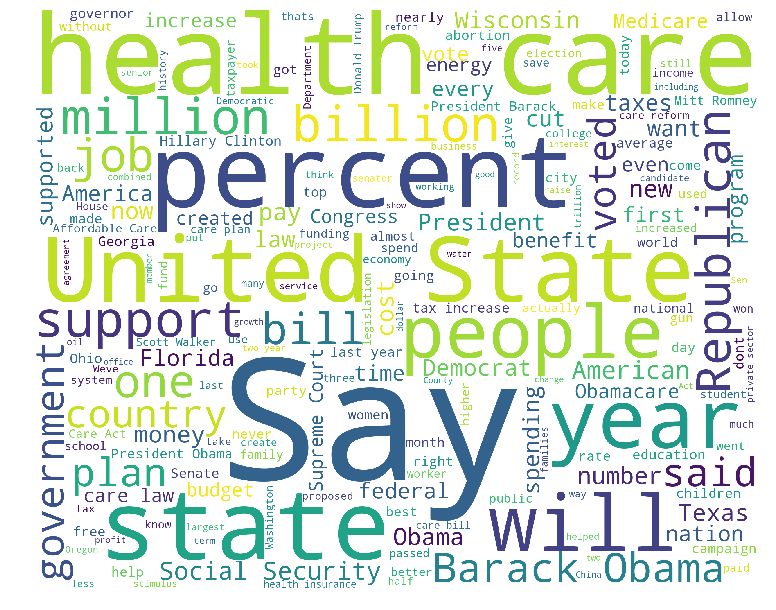

Negative words


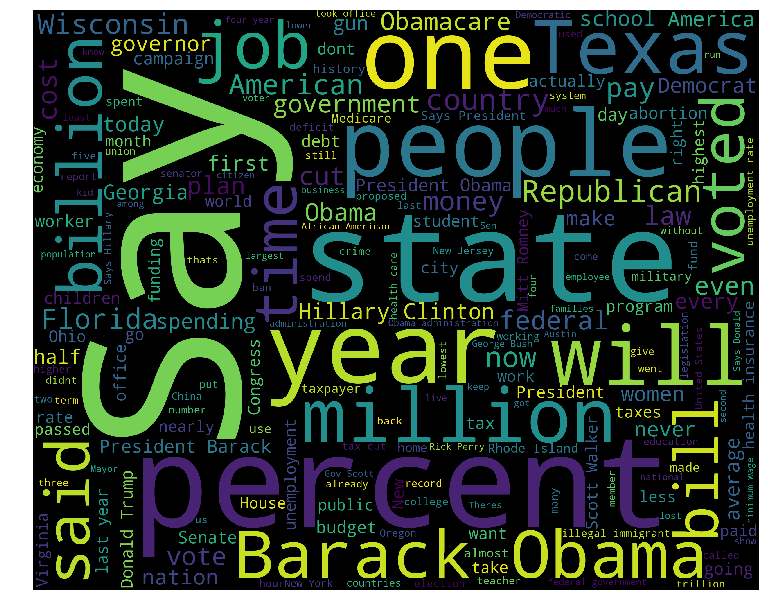

In [342]:
from wordcloud import WordCloud,STOPWORDS
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
positive_words=[] 
negative_words=[]
print("Positive words")
for x in train_data['statement']: 
    ss = sid.polarity_scores(x)
    if ss["compound"] > 0.0:
        positive_words.append(x)
    else:
        negative_words.append(x)
        
wordcloud_draw(positive_words,'white')
print("Negative words")
wordcloud_draw(negative_words)

## Building LDA model using Bag of Words on the Data set
* Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.
* LDA returns a vector of topic probabilities for each document.


#### Get word frequency using nltk to get a word frequency (by count)  and  keep the top most used words to train the LDA model 

In [343]:
import nltk
from nltk import FreqDist
# first get a list of all words
all_words = [word for item in list(train_data['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words
#all_words

8502

In [344]:
# choose k and visually inspect the bottom 10 words of the top k
k = 1800
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('shaheen', 8),
 ('resolut', 8),
 ('arkansa', 8),
 ('camp', 8),
 ('battl', 8),
 ('civilian', 8),
 ('proport', 8),
 ('harass', 8),
 ('tabl', 8),
 ('gang', 8)]

In [345]:
# choose k and visually inspect the bottom 10 words of the top k
k =1900
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('marin', 7),
 ('compromis', 7),
 ('sens', 7),
 ('mosqu', 7),
 ('tweet', 7),
 ('item', 7),
 ('delet', 7),
 ('statement', 7),
 ('phil', 7),
 ('funnel', 7)]

In [444]:
# define a function only to keep words in the top k words
k=5
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [447]:
top_k_words

{'percent', 'say', 'state', 'tax', 'year'}

In [348]:
# document length
train_data['doc_len'] = train_data['tokenized'].apply(lambda x: len(x))
doc_lengths = list(train_data['doc_len'])
train_data.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 10240 
average document length 10.50146484375 
minimum document length 1 
maximum document length 184


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


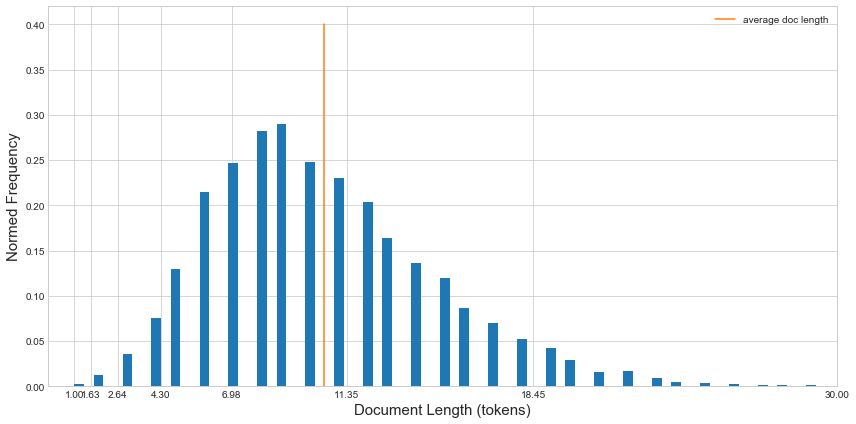

In [349]:
# plot a histogram of document length
num_bins = 500
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, normed=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(1),stop=np.log10(30),num=8, base=10.0))
plt.xlim(0,30)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.4,9)], np.linspace(0.0,0.4,9), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

###  It is useful to get the document length distribution to understand which model to choose. 
* For applying LDA it is advised to drop short articles as LDA does not work very well on short documents, so I will drop some of the shorter articles before training the model.



In [350]:
texts= list(texts)
#texts

In [351]:

dict_tokenized = gensim.corpora.Dictionary(texts)
count = 0
for k, v in dict_tokenized.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abus
1 account
2 administr
3 advantag
4 afghanistan
5 aid
6 america
7 american
8 amount
9 armi
10 attack


### Gensim doc2bow

For each document we create a dictionary reporting how many
words and how many times those words appear. Save this to ‘bow_corpus’

In [353]:
dict_bow_corpus = [dict_tokenized.doc2bow(doc) for doc in texts]
#dict_bow_corpus[0]


## Training LDA model using gensim.models.LdaMulticore for statements in training dataset

In [354]:
lda_model = gensim.models.LdaMulticore(dict_bow_corpus, num_topics=10, id2word=dict_tokenized, passes=2, workers=2)

### For each topic, LDA displays the words occuring in that topic and its relative weight.





In [355]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.006*"ga" + 0.006*"bill" + 0.006*"labor" + 0.006*"fund" + 0.006*"germani" + 0.006*"india" + 0.006*"hous" + 0.006*"abus" + 0.006*"societi" + 0.006*"fight"
Topic: 1 
Words: 0.007*"invest" + 0.006*"deficit" + 0.006*"citi" + 0.006*"diseas" + 0.006*"offici" + 0.006*"cost" + 0.006*"crime" + 0.006*"primari" + 0.006*"immigr" + 0.006*"germani"
Topic: 2 
Words: 0.006*"vote" + 0.006*"poll" + 0.006*"defens" + 0.006*"democrat" + 0.006*"polici" + 0.006*"govern" + 0.006*"sale" + 0.006*"american" + 0.006*"kill" + 0.006*"worth"
Topic: 3 
Words: 0.007*"account" + 0.006*"russia" + 0.006*"goal" + 0.006*"rule" + 0.006*"delay" + 0.006*"parent" + 0.006*"murder" + 0.006*"charg" + 0.006*"offici" + 0.006*"inaccuraci"
Topic: 4 
Words: 0.007*"candid" + 0.006*"rate" + 0.006*"shot" + 0.006*"immigr" + 0.006*"bank" + 0.006*"school" + 0.006*"power" + 0.006*"chines" + 0.006*"financ" + 0.006*"law"
Topic: 5 
Words: 0.006*"israel" + 0.006*"attorney" + 0.006*"author" + 0.006*"diseas" + 0.006*"russia" + 0.

In [356]:
corpus_tfidf

### Running LDA using TF-IDF
* Create tf-idf model object using models.TfidfModel on ‘bow_corpus’.
* Apply transformation to the entire corpus. 


In [357]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dict_tokenized, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"
Topic: 1 Word: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"
Topic: 2 Word: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"
Topic: 3 Word: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"
Topic: 4 Word: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"
Topic: 5 Word: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"

/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:804: RuntimeWarning: invalid value encountered in double_scalars
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


### Performance evaluation of LDA model for classifying sample document using Bag of Words

In [358]:
for index, score in sorted(lda_model[dict_bow_corpus[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.994736909866333	 
Topic: 0.006*"vote" + 0.006*"poll" + 0.006*"defens" + 0.006*"democrat" + 0.006*"polici" + 0.006*"govern" + 0.006*"sale" + 0.006*"american" + 0.006*"kill" + 0.006*"worth"


### Performance evaluation of LDA model on tfidf for classifying sample document

In [450]:
for index, score in sorted(lda_model_tfidf[dict_bow_corpus[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.17568069696426392	 
Topic: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"

Score: 0.16911260783672333	 
Topic: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"

Score: 0.15381790697574615	 
Topic: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"

Score: 0.13531452417373657	 
Topic: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"

Score: 0.09463118761777878	 
Topic: 0.006*"poll" + 0.006*"power" + 0.006*"parent" + 0.006*"parti" + 0.006*"patient" + 0.006*"peac" + 0.006*"polic" + 0.006*"polici" + 0.006*"polit" + 0.006*"oil"

Score: 0.085820920765399

### Performance of LDA without TF-idf is better than LDA with TF-idf

## Testing model on unseen document

In [360]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [361]:
unseen_document = 'How a Pentagon deal became an identity crisis for Google'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
tmp=sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1])[0][1]
print(tmp)


0.5499992


## Calculate LDA score for the News Statement from training dataset 

In [452]:

LDA_score=[]
count = 0
for doc in train_data['statement']:
    if(count<10):
        bow_vector = dictionary.doc2bow(preprocess(doc))
        tmp=sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1])[0][1]
        LDA_score.append(tmp)
        print(doc,'=>',tmp)
        print ('\n')
    count+=1

Says the Annies List political group supports third-trimester abortions on demand. => 0.6999995


When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration. => 0.6999995


Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran." => 0.7749997


Health care reform legislation is likely to mandate free sex change surgeries. => 0.7749997


The economic turnaround started at the end of my term. => 0.1


The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades. => 0.5499992


Jim Dunnam has not lived in the district he represents for years now. => 0.1


I'm the only person on this stage who has worked actively just last year passing, along with Russ Feingold, some of the toughest ethics reform since Watergate. => 0.5499991


However, it took $19.5 million in Oregon 

### Appending LDA_score to the training dataset 'LDA_controversy_score'

In [364]:
train_data['LDA_controversy_score']= LDA_score

In [365]:
train_data.head()

,id,label,statement,subjects,speaker,speaker_job,state,party,barely_true_counts,false_counts,...,verb_count,adj_count,adv_count,pron_count,stemmed,tokenized,LSA_controversy_score,cosine_similarity_tfidf,sentiment_polarity,LDA_controversy_score
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,...,0,0,0,0,say anni list polit group support third trimes...,"[say, anni, list, polit, group, support, third...",0.153393,0.008388,positive,0.700
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,...,0,0,0,0,declin coal start start natur gas took start b...,"[declin, coal, start, start, natur, ga, took, ...",0.153393,0.011632,positive,0.700
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,...,0,0,0,0,hillari clinton agre john mccain vote give geo...,"[hillari, clinton, agre, john, mccain, vote, g...",0.230089,0.022815,positive,0.775
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,...,0,0,0,0,health care reform legisl like mandat free sex...,"[health, care, reform, legisl, like, mandat, f...",0.306786,0.041288,positive,0.775
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,...,0,0,0,0,econom turnaround start end term,"[econom, turnaround, start, end, term]",0.000000,0.000000,neutral,0.100


In [366]:
lda_model.show_topics(num_topics=10, num_words=20)

[(0,
  '0.006*"ga" + 0.006*"bill" + 0.006*"labor" + 0.006*"fund" + 0.006*"germani" + 0.006*"india" + 0.006*"hous" + 0.006*"abus" + 0.006*"societi" + 0.006*"fight" + 0.006*"syria" + 0.006*"popul" + 0.006*"spend" + 0.006*"law" + 0.006*"rais" + 0.006*"goal" + 0.006*"support" + 0.006*"attack" + 0.006*"candid" + 0.006*"comment"'),
 (1,
  '0.007*"invest" + 0.006*"deficit" + 0.006*"citi" + 0.006*"diseas" + 0.006*"offici" + 0.006*"cost" + 0.006*"crime" + 0.006*"primari" + 0.006*"immigr" + 0.006*"germani" + 0.006*"financ" + 0.006*"restrict" + 0.006*"shoot" + 0.006*"mexico" + 0.006*"nation" + 0.006*"gun" + 0.006*"usa" + 0.006*"offens" + 0.006*"investig" + 0.006*"worth"'),
 (2,
  '0.006*"vote" + 0.006*"poll" + 0.006*"defens" + 0.006*"democrat" + 0.006*"polici" + 0.006*"govern" + 0.006*"sale" + 0.006*"american" + 0.006*"kill" + 0.006*"worth" + 0.006*"countri" + 0.006*"sector" + 0.006*"washington" + 0.006*"union" + 0.006*"popul" + 0.006*"korea" + 0.006*"dollar" + 0.006*"war" + 0.006*"compani" + 0.0

In [367]:
lda_model.show_topic(topicid=4, topn=20)

[('candid', 0.00650933),
 ('rate', 0.006486833),
 ('shot', 0.0064660423),
 ('immigr', 0.0064397687),
 ('bank', 0.006382904),
 ('school', 0.0063546915),
 ('power', 0.0063374876),
 ('chines', 0.0063070105),
 ('financ', 0.0063050576),
 ('law', 0.006292212),
 ('russian', 0.006269924),
 ('concern', 0.0062669665),
 ('polic', 0.00625263),
 ('educ', 0.0062271347),
 ('job', 0.006202499),
 ('debt', 0.006199169),
 ('spend', 0.006198469),
 ('campaign', 0.006192863),
 ('store', 0.0061588334),
 ('israel', 0.0061588055)]

In [368]:
lda_model.show_topic(topicid=9, topn=20)

[('credit', 0.006459017),
 ('support', 0.006404957),
 ('rais', 0.0063363127),
 ('syrian', 0.006316674),
 ('expect', 0.0062888893),
 ('job', 0.0062711933),
 ('ban', 0.006236854),
 ('campaign', 0.006229737),
 ('budget', 0.006211951),
 ('korea', 0.0061808494),
 ('compani', 0.0061780117),
 ('forc', 0.0061608404),
 ('power', 0.006160616),
 ('world', 0.006139991),
 ('cut', 0.006137857),
 ('progress', 0.006135764),
 ('polic', 0.0061357277),
 ('unemploy', 0.0061226846),
 ('justic', 0.006122376),
 ('reason', 0.006115057)]

## A final comparison…
I have used three different approaches for document similarity: 
* Transform the documents into tf-idf vectors, then compute the cosine similarity between them.
* Applying LDA on the whole corpus then using the LDA model to create the vector for each document and compute similarity using LDA score. 
* Applying LDA on tfidf vectors.
* Applying LSA on the dictionary corpus and then adding the news statements to the LSA model which vectorizes each statement and computes similarity.


### Based on my analysis, I am getting more accurate score for controversy (document similarity) using LDA without tf-idf . 
LDA TF-IDF model did not perform better, since it calculates score based on frequency of terms appearing in my vocab document.

In [369]:
train_data.keys()

Index(['id', 'label', 'statement', 'subjects', 'speaker', 'speaker_job',
       'state', 'party', 'barely_true_counts', 'false_counts',
       'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts',
       'context', 'text-length', 'label_id', 'noun_count', 'verb_count',
       'adj_count', 'adv_count', 'pron_count', 'stemmed', 'tokenized',
       'LSA_controversy_score', 'cosine_similarity_tfidf',
       'sentiment_polarity', 'LDA_controversy_score'],
      dtype='object')

In [387]:
train_data[['statement','sentiment_polarity', 'cosine_similarity_tfidf','LSA_controversy_score', 'LDA_controversy_score']][:10]

,statement,sentiment_polarity,cosine_similarity_tfidf,LSA_controversy_score,LDA_controversy_score
0,Says the Annies List political group supports ...,positive,0.008388,0.153393,0.700000
1,When did the decline of coal start? It started...,positive,0.011632,0.153393,0.700000
2,"Hillary Clinton agrees with John McCain ""by vo...",positive,0.022815,0.230089,0.775000
3,Health care reform legislation is likely to ma...,positive,0.041288,0.306786,0.775000
4,The economic turnaround started at the end of ...,neutral,0.000000,0.000000,0.100000
5,The Chicago Bears have had more starting quart...,negative,0.000000,0.076696,0.549999
6,Jim Dunnam has not lived in the district he re...,neutral,0.000000,0.000000,0.100000
7,I'm the only person on this stage who has work...,positive,0.010576,0.076696,0.549999
8,"However, it took $19.5 million in Oregon Lotte...",neutral,0.013121,0.153393,0.700000
9,Says GOP primary opponents Glenn Grothman and ...,neutral,0.018862,0.306786,0.820000


## TFIDF model - vectorizing dataset to include unigrams and bigrams
* Term Frequency, Inverse Document Frequency, is used to calculate a tf-idf vector for each of the news statements:
* sublinear_df is set to True to use a logarithmic form for frequency.
* min_df is the minimum numbers of documents a word must be present in to be kept.
* norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
* ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
* stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.

In [147]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf_vect.fit_transform(train_data.stemmed).toarray()
labels = train_data.label_id
features.shape

(10240, 4127)

Now, each of 10240 statements is represented by 4127 features, representing the tf-idf score for different unigrams and bigrams.

We can use sklearn.feature_selection.chi2 to find the terms that are the most correlated with each:

In [148]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for label, label_id in sorted(label_to_id.items()):
    features_chi2 = chi2(features, labels == label_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_vect.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(label))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'barely-true':
  . Most correlated unigrams:
. benghazi
. bid
  . Most correlated bigrams:
. feder reserv
. say billion
# 'false':
  . Most correlated unigrams:
. debunk
. terri
  . Most correlated bigrams:
. vice presid
. terri mcauliff
# 'half-true':
  . Most correlated unigrams:
. anytim
. indiana
  . Most correlated bigrams:
. say administr
. cost georgia
# 'mostly-true':
  . Most correlated unigrams:
. visa
. owe
  . Most correlated bigrams:
. rate sinc
. highest corpor
# 'pants-fire':
  . Most correlated unigrams:
. transact
. socialist
  . Most correlated bigrams:
. say barack
. zero job
# 'true':
  . Most correlated unigrams:
. compens
. georgia
  . Most correlated bigrams:
. percent hispan
. percent vote


## Training multi-label classifier using CountVectorizer and TfidfTransformer
## Models suitable for multinomial variant:
* Train using vectorized Statements and label columns 
* Logistic Regression
* (Multinomial) Naive Bayes
* Linear Support Vector Machine
* Random Forest

In [149]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(train_data['stemmed'], train_data['label'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [150]:
print(clf.predict(count_vect.transform(["Says when armed civilians stop mass shootings with guns, an average of 2.5 people die; otherwise, an average of 18 people die"])))

['true']


## Training models using Multinomial naive Bayes, Logistic Regression, RandomForestClassifier and Support Vector Machine

In [152]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])



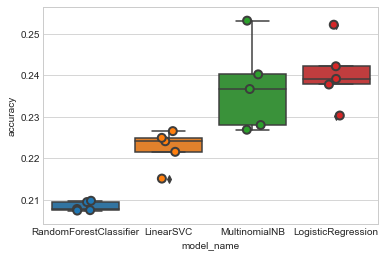

In [153]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()



### Multinomial Naive Bayes and Logistic Regression perform better than the other two classifiers.

In [154]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.222463
LogisticRegression        0.240327
MultinomialNB             0.237006
RandomForestClassifier    0.208399
Name: accuracy, dtype: float64

### Using LinearSVC model to  print confusion matrix, and see the discrepancies between predicted and actual labels.

In [157]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, train_data.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


 ### The following code block computes heat map of confusion matrix and shows variance between predicted and actual labels
 * Due to large number of iteration, it runs indefinitely, hence commented

In [454]:
# from sklearn.metrics import confusion_matrix
# conf_mat = confusion_matrix(y_test, y_pred)
# fig, ax = plt.subplots(figsize=(10,10))
# sns.heatmap(conf_mat, annot=True, fmt='d',
#             xticklabels=label_id_df.label.values, yticklabels=label_id_df.label.values)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show()

In [ ]:
# from IPython.display import display
# for predicted in label_id_df.category_id:
#     for actual in label_id_df.category_id:
#         if predicted != actual and conf_mat[actual, predicted] >= 10:
#             print("'{}' predicted as '{}' : {} examples.".format(id_to_label[actual], id_to_label[predicted], conf_mat[actual, predicted]))
#             display(train_data.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['label', 'statement']])
#             print('')

### I applied the chi-squared test to find the terms that are the most correlated with each of the labels:

In [158]:
model.fit(features, labels)
N = 2
for label, label_id in sorted(label_to_id.items()):
    indices = np.argsort(model.coef_[label_id])
    feature_names = np.array(tfidf_vect.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(label))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'barely-true':
  . Top unigrams:
       . bid
       . mention
  . Top bigrams:
       . say billion
       . administr spent
# 'false':
  . Top unigrams:
       . debunk
       . jan
  . Top bigrams:
       . say mani
       . make million
# 'half-true':
  . Top unigrams:
       . anytim
       . mammogram
  . Top bigrams:
       . elect year
       . congress pass
# 'mostly-true':
  . Top unigrams:
       . decemb
       . sixth
  . Top bigrams:
       . fund billion
       . say jeff
# 'pants-fire':
  . Top unigrams:
       . transact
       . blue
  . Top bigrams:
       . zero job
       . law pass
# 'true':
  . Top unigrams:
       . heavili
       . compens
  . Top bigrams:
       . sen obama
       . feder minimum


### The classification report for each class:

In [159]:
from sklearn import metrics
print(confusion_matrix(y_test, y_pred))
print('\n')
print(metrics.classification_report(y_test, y_pred, target_names=train_data['label'].unique()))

[[165 138 116  94  97  50]
 [147 191 150  94  86  38]
 [ 87 152 160 112  96  30]
 [104 111 148 109  64  18]
 [115 124 103  81  93  37]
 [ 61  51  43  31  47  37]]


             precision    recall  f1-score   support

      false       0.24      0.25      0.25       660
  half-true       0.25      0.27      0.26       706
mostly-true       0.22      0.25      0.24       637
       true       0.21      0.20      0.20       554
barely-true       0.19      0.17      0.18       553
 pants-fire       0.18      0.14      0.15       270

avg / total       0.22      0.22      0.22      3380



### Use CountVectorizer to fit the training statements and apply Multinomial Naive Bayes

In [160]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(train_data['statement'])

In [161]:
review_5 = train_data['statement'][4]
review_5

'The economic turnaround started at the end of my term.'

In [162]:
bow_5 = bow_transformer.transform([review_5])
print(bow_5)

  (0, 7940)	1
  (0, 8076)	1
  (0, 13219)	1
  (0, 13658)	1
  (0, 14018)	1


In [163]:
print(bow_transformer.get_feature_names()[13219])
print(bow_transformer.get_feature_names()[13658])

started
term


In [164]:
X = bow_transformer.transform(train_data['statement'])

In [165]:
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)
# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (10240, 14694)
Amount of Non-Zero occurrences:  109603
Density: 0.07284209860317137


In [166]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, train_data['label'], test_size=0.3, random_state=101)

In [167]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [168]:
preds = nb.predict(X_test)

In [169]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[ 80 107 154 101  12  46]
 [ 80 149 176 122  11  51]
 [ 67  91 242 155   9  54]
 [ 46  96 188 186   8  69]
 [ 38  63  69  31  20  20]
 [ 40  81 177 152   7  74]]


             precision    recall  f1-score   support

barely-true       0.23      0.16      0.19       500
      false       0.25      0.25      0.25       589
  half-true       0.24      0.39      0.30       618
mostly-true       0.25      0.31      0.28       593
 pants-fire       0.30      0.08      0.13       241
       true       0.24      0.14      0.18       531

avg / total       0.25      0.24      0.23      3072



### The model accuracy is not great, so it has to be improved by boosting or ensemble methods, and adding more features to train the model

# Word2vec and T-Sne plot visualization

The Word to Vec model produces a vocabulary, with each word being represented by an n-dimensional numpy array (100 values in this case)

In [170]:
from gensim.models import word2vec
model = word2vec.Word2Vec(train_data['tokenized'], size=100, window=20, min_count=200, workers=4)
model.wv['say']

array([-0.07374749, -0.01454735, -0.33069184, -0.1097273 ,  0.02759043,
       -0.09435339,  0.10885961, -0.01794994,  0.06232359, -0.06855305,
       -0.04211739, -0.08506902, -0.14755055,  0.04442786,  0.03521668,
        0.05104778,  0.33428732, -0.05724892,  0.21898489, -0.20616713,
        0.16578455, -0.16460735,  0.02182161, -0.12921062,  0.06365736,
        0.2564674 ,  0.09248681,  0.00048073, -0.02152466,  0.08901426,
       -0.17283967,  0.17657115, -0.13396336, -0.06760427,  0.24715413,
       -0.13102564,  0.04001468,  0.11840147, -0.06368446, -0.00714921,
        0.1325107 ,  0.0172634 ,  0.11450408,  0.20048866,  0.05634848,
       -0.04827746,  0.19149734, -0.30689877,  0.13573758,  0.11245354,
        0.01771527, -0.15646732,  0.06282207, -0.03725885, -0.23357087,
        0.11685649, -0.09451819, -0.11972658, -0.1486295 ,  0.298896  ,
        0.1644642 ,  0.00733753, -0.12127444, -0.00754472, -0.05679278,
       -0.04810264,  0.3372263 ,  0.13956797, -0.06434648, -0.14

T-sne plot visualization 

In [171]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


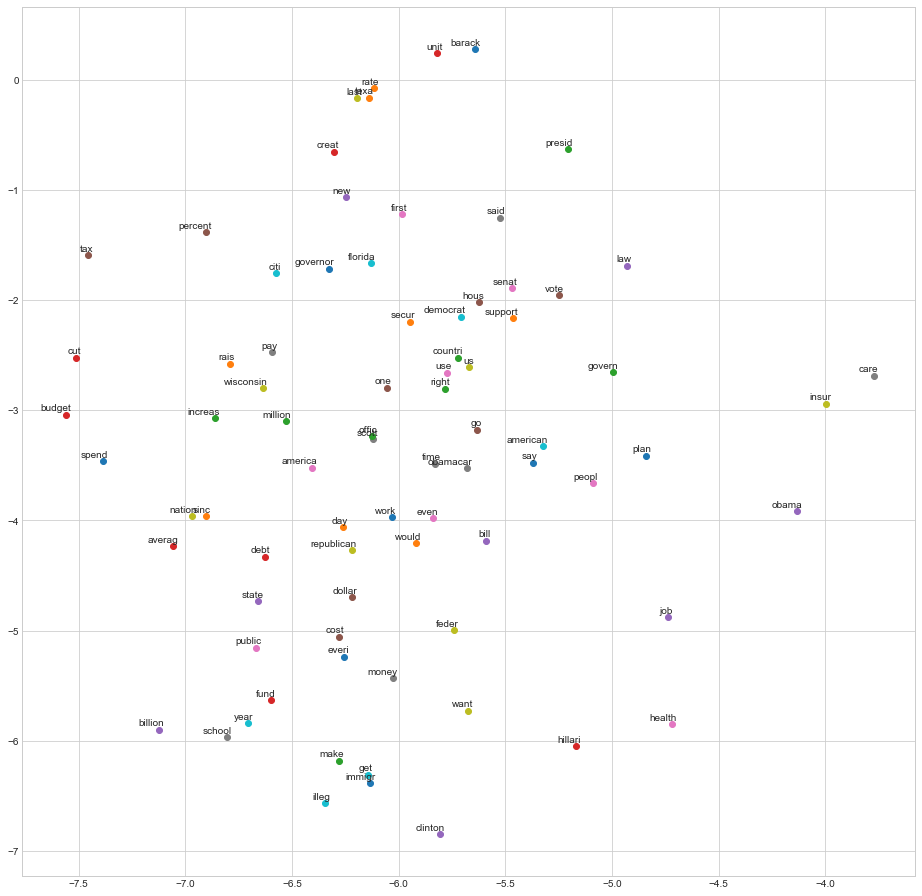

In [172]:
tsne_plot(model)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


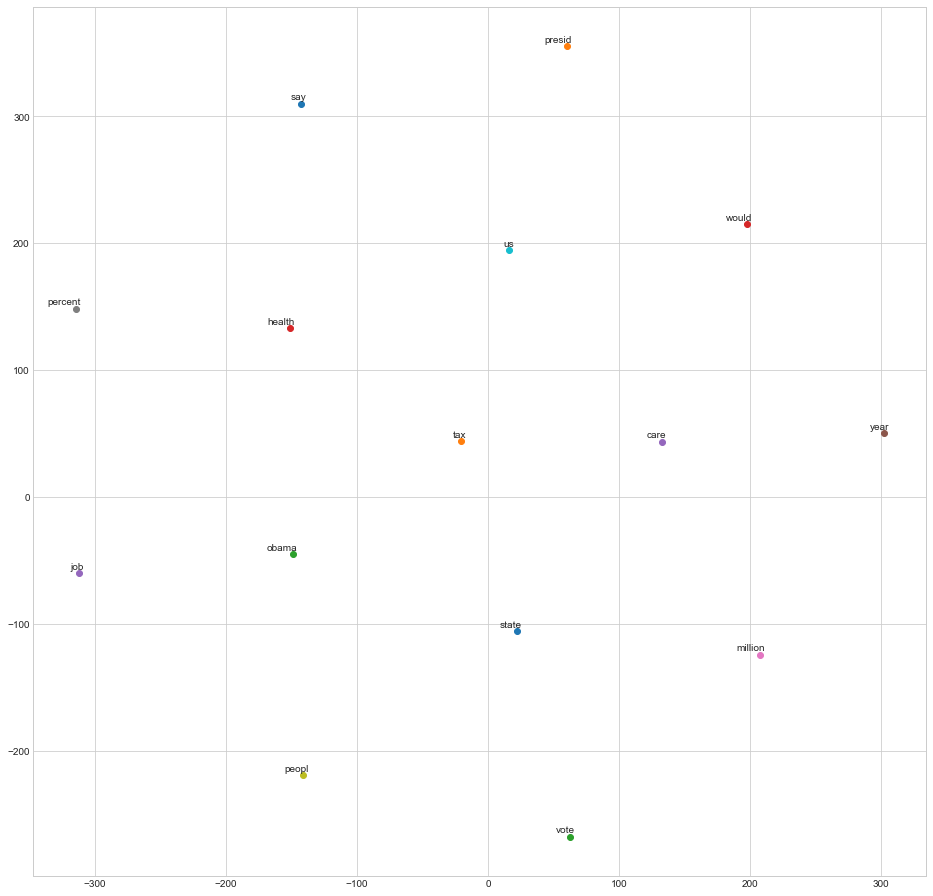

In [173]:
# A more selective model
model = word2vec.Word2Vec(train_data['tokenized'], size=100, window=20, min_count=500, workers=4)
tsne_plot(model)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


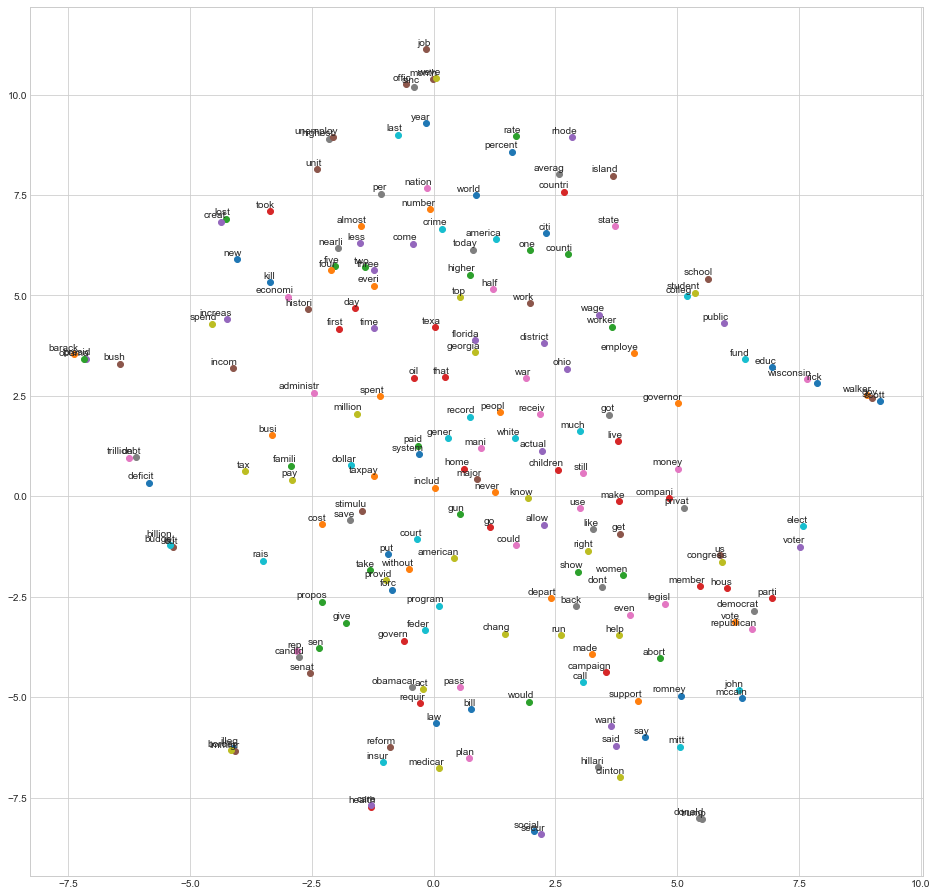

In [174]:
## A less selective model
model = word2vec.Word2Vec(train_data['tokenized'], size=100, window=20, min_count=100, workers=4)
tsne_plot(model)

#### Similar words are grouped together in the plot

In [175]:
model.most_similar('obama')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('presid', 0.9968338012695312),
 ('bush', 0.9946095943450928),
 ('barack', 0.9932442903518677),
 ('administr', 0.991852343082428),
 ('trillion', 0.9898827075958252),
 ('border', 0.9892776012420654),
 ('first', 0.9892233610153198),
 ('war', 0.9891954660415649),
 ('put', 0.9889378547668457),
 ('debt', 0.9888296723365784)]

In [176]:
model.most_similar('dollar')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('taxpay', 0.9991417527198792),
 ('spent', 0.9989352226257324),
 ('money', 0.9988281726837158),
 ('save', 0.9987137317657471),
 ('includ', 0.998674750328064),
 ('paid', 0.9986252188682556),
 ('much', 0.998600959777832),
 ('gener', 0.99839186668396),
 ('put', 0.9983741044998169),
 ('still', 0.998305082321167)]

## Conclusion - 

#### Enriched dataset with following columns - 
* sentiment_polarity - Using Vader Library. To detect sentiment-loaded language on news articles. I calculated the frequencies of negative/neutral/positive words for each article and use these as input for classifiers. Then, used the algorithm to train the emotion polarity classifier (EP), using both the annotations and sentiment measures.
* cosine_similarity_tfidf - When the documents are similar to the controversy vocabulary, it would imply that the statement is more controversial. The model accuracy was not very accurate.
* LSA_controversy_score - The use of the LSA model shows a noticeable quality improvement compared to
the use of the tfidf model.
* LDA_controversy_score- model implemented to capture the distribution of topics among news documents.
I performed manual evaluations in order to understand the accuracy in similarity scores of the above Topic Models.
( LDA seems to be better than other scores)


##### Applied following Distillation methods- 
* LDA
* LSA
* Sentiment Analysis
* Part of Speech Tagging and filtering - The parts-of-speech tagging from Spacy API was used for this filtering. Only, nouns, adjectives and verbs were left on the documents to make it more meaningful.

##### Applied following multiclass classification models-
* Logistic Regression
* (Multinomial) Naive Bayes
* Linear Support Vector Machine
* Random Forest models 

##### Model Accuracy scores
<div style="width: 300px;">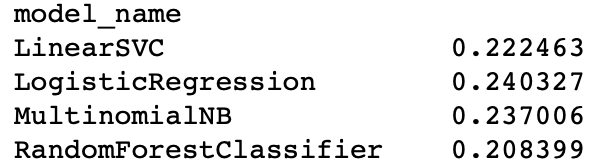





## Next steps
* Improve the Multiclass Classfication model score using boosting, and feature engineering.
* Collaborate with team-members, assign weights for each factor and form polynomial equation for all features combined.